In [2]:
# Load Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
#load data
forcast_data = pd.read_csv(r'C:\Users\ranih\OneDrive\Desktop\Python For Real\Github\Data\Baseball\Hitting\Fangraphs\2016-2019_custom_report_hitting_metrics_3.csv')
forcast_data.head()

,Name,Season,Age,G,PA,AB,R,HR,RBI,SB,...,EV,LA,Barrels,Barrel%,maxEV,HardHit%,Spd,wRC+,WAR,playerid
0,Mookie Betts,2018,25,136,614,520,129,32,80,30,...,92.3,18.5,57,13.10%,110.6,50.20%,7.0,185,10.4,13611
1,Mike Trout,2018,26,140,608,471,101,39,79,24,...,91.2,18.6,54,15.30%,118.0,46.00%,5.9,188,9.6,10155
2,Christian Yelich,2019,27,130,580,489,100,44,97,30,...,93.3,11.3,59,15.80%,117.9,48.70%,6.2,175,7.8,11477
3,Mike Trout,2017,25,114,507,402,92,33,72,22,...,88.8,18.0,38,12.00%,114.7,40.50%,6.2,180,6.8,10155
4,Mike Trout,2019,27,134,600,470,110,45,104,11,...,90.9,22.2,62,17.50%,116.6,43.80%,4.9,178,8.5,10155


In [4]:
print("Dataframe Rows: ", forcast_data.shape[0])
print("Dataframe Columns: ", forcast_data.shape[1])

Dataframe Rows:  1106
Dataframe Columns:  43


In [5]:
# grabbing the features we need
forcast_data =  forcast_data[['Name','Season','G','PA','AB','R','HR','RBI','SB','AVG']]
forcast_data.head()

,Name,Season,G,PA,AB,R,HR,RBI,SB,AVG
0,Mookie Betts,2018,136,614,520,129,32,80,30,0.346
1,Mike Trout,2018,140,608,471,101,39,79,24,0.312
2,Christian Yelich,2019,130,580,489,100,44,97,30,0.329
3,Mike Trout,2017,114,507,402,92,33,72,22,0.306
4,Mike Trout,2019,134,600,470,110,45,104,11,0.291


# Preparing the dataframe for forcasting

In [6]:
forcast_data = forcast_data[(forcast_data['Season'] >= 2017) & (forcast_data['Season'] < 2020)]
forcast_data.head()

,Name,Season,G,PA,AB,R,HR,RBI,SB,AVG
0,Mookie Betts,2018,136,614,520,129,32,80,30,0.346
1,Mike Trout,2018,140,608,471,101,39,79,24,0.312
2,Christian Yelich,2019,130,580,489,100,44,97,30,0.329
3,Mike Trout,2017,114,507,402,92,33,72,22,0.306
4,Mike Trout,2019,134,600,470,110,45,104,11,0.291


In [7]:
name_df_final = forcast_data['Name'].value_counts().to_frame().reset_index()
name_df_final.columns.values[0] = 'Name'
name_df_final.columns.values[1] = "seasons_of_data"
forcast_data = name_df_final.merge(forcast_data, how = 'inner', on = ['Name'])
forcast_data.head()

,Name,seasons_of_data,Season,G,PA,AB,R,HR,RBI,SB,AVG
0,Elvis Andrus,3,2017,158,689,643,100,20,88,25,0.297
1,Elvis Andrus,3,2019,147,648,600,81,12,72,31,0.275
2,Elvis Andrus,3,2018,97,428,395,53,6,33,5,0.256
3,Josh Bell,3,2019,143,613,527,94,37,116,0,0.277
4,Josh Bell,3,2017,159,620,549,75,26,90,2,0.255


In [8]:
forcast_data_grouped = forcast_data.groupby(['Name','Season']).sum()
forcast_data_grouped = forcast_data[forcast_data['seasons_of_data'] >= 3]
forcast_data_grouped = forcast_data_grouped.groupby(['Name','Season']).sum()
forcast_data_grouped.head()

seasons_of_data    G   PA   AB    R  HR  RBI  SB    AVG
Name         Season                                                         
A.J. Pollock 2017                  3  112  466  425   73  14   49  20  0.266
             2018                  3  113  460  413   61  21   65  13  0.257
             2019                  3   86  342  308   49  15   47   5  0.266
Aaron Judge  2017                  3  155  678  542  128  52  114   9  0.284
             2018                  3  112  498  413   77  27   67   6  0.278

In [9]:
fantasy_cats_restind = forcast_data_grouped.reset_index()
fantasy_cats_restind.head(3)

,Name,Season,seasons_of_data,G,PA,AB,R,HR,RBI,SB,AVG
0,A.J. Pollock,2017,3,112,466,425,73,14,49,20,0.266
1,A.J. Pollock,2018,3,113,460,413,61,21,65,13,0.257
2,A.J. Pollock,2019,3,86,342,308,49,15,47,5,0.266


# Forcasting

In [10]:
fantasy_categories = fantasy_cats_restind[['G', 'PA', 'AB', 'R', 'HR', 'RBI','SB', 'AVG']]
fantasy_categories.head(3)

,G,PA,AB,R,HR,RBI,SB,AVG
0,112,466,425,73,14,49,20,0.266
1,113,460,413,61,21,65,13,0.257
2,86,342,308,49,15,47,5,0.266


In [11]:
# seasonal weights to run projections, must add up to .100
three_season_2017 = .20
three_season_2018 = .40
three_season_2019 = .40

In [12]:
season_2017 = fantasy_cats_restind[fantasy_cats_restind['Season'] == 2017]
season_2018 = fantasy_cats_restind[fantasy_cats_restind['Season'] == 2018]
season_2019 = fantasy_cats_restind[fantasy_cats_restind['Season'] == 2019]

In [13]:
season_2017 = season_2017.groupby(['Name','Season']).mean()
season_2018 = season_2018.groupby(['Name','Season']).mean()
season_2019 = season_2019.groupby(['Name','Season']).mean()

In [14]:
weighted_stats_2017  = []
for col_name in fantasy_categories:
    value = season_2017[col_name]  * three_season_2017 
    #print(col_name)
    #print(value)
    weighted_stats_2017.append(value)

In [15]:
weighted_stats_2018  = []
for col_name in fantasy_categories:
    value = season_2018[col_name]  * three_season_2018 
    #print(col_name)
    #print(value)
    weighted_stats_2018.append(value)

In [16]:
weighted_stats_2019  = []
for col_name in fantasy_categories:
    value = season_2019[col_name]  * three_season_2019 
    #print(col_name)
    #print(value)
    weighted_stats_2019.append(value)

In [17]:
forcast_2017 = pd.DataFrame(weighted_stats_2017)
forcast_2017 = forcast_2017.T

In [18]:
forcast_2018 = pd.DataFrame(weighted_stats_2018)
forcast_2018 = forcast_2018.T

In [19]:
forcast_2019 = pd.DataFrame(weighted_stats_2019)
forcast_2019 = forcast_2019.T

In [20]:
dfs  = [forcast_2017,forcast_2018,forcast_2019]
three_seasons_final_forcast = pd.concat(dfs)
three_seasons_final_forcast.reset_index(inplace=True)
three_seasons_final_forcast =  three_seasons_final_forcast.groupby(['Name']).sum()
three_seasons_final_forcast.drop('Season',axis=1,inplace=True)

In [21]:
three_seasons_final_forcast.head(5)

,G,PA,AB,R,HR,RBI,SB,AVG
Name,,,,,,,,
A.J. Pollock,102.0,414.0,373.4,58.6,17.2,54.6,11.2,0.2624
Aaron Judge,116.6,513.6,424.8,86.4,32.0,71.6,5.4,0.2768
Adam Frazier,130.2,474.8,430.0,63.8,9.2,44.6,4.2,0.2772
Adam Jones,142.2,583.4,545.4,64.4,17.6,66.6,4.0,0.2734
Albert Almora Jr.,139.2,401.4,373.0,49.0,8.4,38.4,1.4,0.2684


In [22]:
avg = three_seasons_final_forcast['AVG']
avg = round(avg,3)
avg

Name
A.J. Pollock         0.262
Aaron Judge          0.277
Adam Frazier         0.277
Adam Jones           0.273
Albert Almora Jr.    0.268
                     ...  
Yasiel Puig          0.266
Yasmani Grandal      0.244
Yolmer Sanchez       0.251
Yonder Alonso        0.233
Yuli Gurriel         0.295
Name: AVG, Length: 152, dtype: float64

In [23]:
three_seasons_final_forcast = round(three_seasons_final_forcast.iloc[:,0:7],0)
three_seasons_final_forcast['AVG'] = avg
three_seasons_final_forcast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, A.J. Pollock to Yuli Gurriel
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       152 non-null    float64
 1   PA      152 non-null    float64
 2   AB      152 non-null    float64
 3   R       152 non-null    float64
 4   HR      152 non-null    float64
 5   RBI     152 non-null    float64
 6   SB      152 non-null    float64
 7   AVG     152 non-null    float64
dtypes: float64(8)
memory usage: 14.8+ KB


In [24]:
final_df = three_seasons_final_forcast.copy().reset_index()
final_df.head()

,Name,G,PA,AB,R,HR,RBI,SB,AVG
0,A.J. Pollock,102.0,414.0,373.0,59.0,17.0,55.0,11.0,0.262
1,Aaron Judge,117.0,514.0,425.0,86.0,32.0,72.0,5.0,0.277
2,Adam Frazier,130.0,475.0,430.0,64.0,9.0,45.0,4.0,0.277
3,Adam Jones,142.0,583.0,545.0,64.0,18.0,67.0,4.0,0.273
4,Albert Almora Jr.,139.0,401.0,373.0,49.0,8.0,38.0,1.0,0.268


In [25]:
final_df[(final_df['HR'] >= 2) & (final_df['HR'] <= 2)]

,Name,G,PA,AB,R,HR,RBI,SB,AVG
15,Billy Hamilton,137.0,490.0,444.0,63.0,2.0,25.0,34.0,0.231


# Functions Used

In [26]:
plt_df = forcast_data.copy()
plt_df.head()

,Name,seasons_of_data,Season,G,PA,AB,R,HR,RBI,SB,AVG
0,Elvis Andrus,3,2017,158,689,643,100,20,88,25,0.297
1,Elvis Andrus,3,2019,147,648,600,81,12,72,31,0.275
2,Elvis Andrus,3,2018,97,428,395,53,6,33,5,0.256
3,Josh Bell,3,2019,143,613,527,94,37,116,0,0.277
4,Josh Bell,3,2017,159,620,549,75,26,90,2,0.255


In [27]:
def player_projection(player_name):
    player_projection = final_df[final_df['Name'] == player_name]
    
    player_score = int(player_projection['HR'])
    
    score_less_than = player_score - 2
    score_less_than = int(score_less_than)
    
    score_greater_than = player_score + 2
    score_greater_than = int(score_greater_than)
    
    return player_projection, score_greater_than, score_less_than

In [28]:
def similar_players(final_df, player_name): # use ML but input will be the players projection
    range_players = final_df[(final_df['HR'] >= score_greater_than) & (final_df['HR'] <= score_less_than)]
    
    return range_players

In [29]:
from sklearn.utils import shuffle

In [30]:
def similar_players(final_df, player_name):
    
    player = final_df[final_df['Name'] == player_name]
    final_df_grp = final_df.groupby('Name').mean()
    
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(final_df_grp)
    
    Kmeans = KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=2141)
    Kmeans.fit(scaled_features)
    
    final_df_grp['cluster'] = Kmeans.labels_
    cluster_1 = final_df_grp[final_df_grp['cluster'] == 0]
    cluster_2 = final_df_grp[final_df_grp['cluster'] == 1]
    cluster_3 = final_df_grp[final_df_grp['cluster'] == 2]
    
    dfs = [cluster_1, cluster_2, cluster_3]
    cluster_df = pd.concat(dfs)
    cluster_df.reset_index(inplace=True)
    player_cluster = cluster_df[cluster_df['Name'] == player_name]
    
    
    
    matching_df = pd.merge(cluster_df, player_cluster, on= 'cluster')
  
    #matching_df = matching_df[matching_df['Name_y'] != player_name]
        
    
    return player_cluster, matching_df, cluster_1, cluster_2, cluster_3

In [31]:
def plot_player_data(player_name, col_name):
    player_plot = forcast_data_2_new_index[forcast_data_2_new_index['Name'] == player_name]
    wrc_graph = sns.scatterplot(data=player_plot, x='Season', y= col_name  )
    plt.xticks([2017, 2018, 2019])
    #plt.show()
    return wrc_graph

In [32]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [33]:
 forcast_data.quantile(.5)

seasons_of_data       3.000
Season             2018.000
G                   132.000
PA                  502.500
AB                  450.000
R                    61.500
HR                   17.000
RBI                  60.000
SB                    4.000
AVG                   0.261
Name: 0.5, dtype: float64

# Player Tool

Enter player name: Kris Bryant


Kris Bryant 2021 projects and cluster group:
            Name      G     PA     AB     R    HR   RBI   SB    AVG  cluster
129  Kris Bryant  130.0  569.0  483.0  89.0  23.0  66.0  4.0  0.281        2

List of players that are in the same cluster as  Kris Bryant

                Name_x    G_x   PA_x   AB_x   R_x  HR_x  RBI_x  SB_x  AVG_x
0          Aaron Judge  117.0  514.0  425.0  86.0  32.0   72.0   5.0  0.277
1           Adam Jones  142.0  583.0  545.0  64.0  18.0   67.0   4.0  0.273
2        Albert Pujols  129.0  544.0  501.0  53.0  21.0   83.0   2.0  0.244
3          Alex Gordon  146.0  589.0  520.0  64.0  12.0   61.0   8.0  0.246
4    Andrelton Simmons  131.0  539.0  499.0  61.0  10.0   60.0  12.0  0.278
5    Andrew Benintendi  145.0  642.0  563.0  87.0  16.0   80.0  16.0  0.277
6     Asdrubal Cabrera  138.0  550.0  493.0  68.0  19.0   78.0   2.0  0.265
7     Brandon Crawford  148.0  576.0  516.0  60.0  13.0   61.0   3.0  0.243
8        Brett Gardne

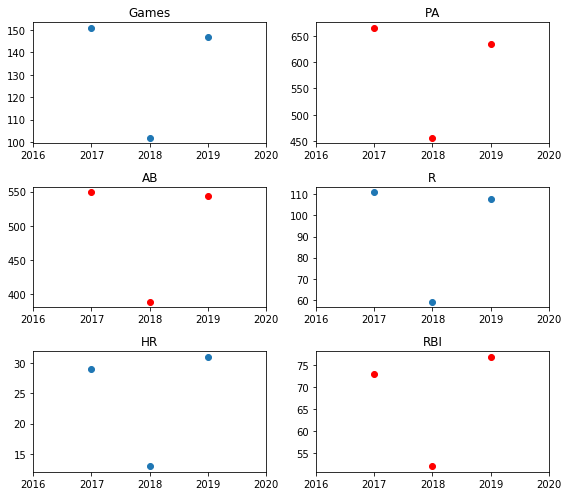

In [42]:
final_df = shuffle(final_df)
player_name = input("Enter player name: ")
plt_df = forcast_data[forcast_data['Name'] == player_name]
projection = player_projection(player_name)
player_cluster, matching_df, cluster_1, cluster_2, cluster_3 = similar_players(final_df, player_name)
print("")
#print("Here is", player_name,"'s", "2021 projection: ")
#print(projection)
print("")
print(player_name, "2021 projects and cluster group:")
print(player_cluster)
print("")
print("List of players that are in the same cluster as ", player_name)
print("")
#print(matching_df.iloc[:10,:10])
matching_df.drop(['Name_y', 'G_y', 'PA_y', 'AB_y', 'R_y', 'HR_y',
       'RBI_y', 'SB_y', 'AVG_y'], axis=1, inplace=True)
print(matching_df.iloc[:,:-1])
print("")
print("Three year average for ", player_name)
print("")
print("Games: ", round(plt_df["G"].mean(),0))
print("Plate Apperances: ", round(plt_df["PA"].mean(),0)) 
print("Runs: ", round(plt_df["R"].mean(),0)) 
print("Homeruns: ", round(plt_df["HR"].mean(),0)) 
print("Runs Batted In: ", round(plt_df["RBI"].mean(),0)) 
print("Stolen Bases: ", round(plt_df["SB"].mean(),0)) 
print("Batting Average: ", round(plt_df["AVG"].mean(),3))



print("")
print(player_name, 'three year trend: ')
fig, ax = plt.subplots(3, 2,figsize=(8,7) ) # allows for multiple plots in the same layout
# top 2 plots
ax[0,0].plot(plt_df['Season'],plt_df['G'], "o")
ax[0,0].set_xlim([2016,2020])
ax[0, 0].set_title('Games')

ax[0,1].plot(plt_df['Season'],plt_df['PA'], "ro")
ax[0,1].set_xlim([2016,2020])
ax[0,1].set_title('PA')

# middle 2 plots}
ax[1,0].plot(plt_df['Season'],plt_df['AB'], "ro")
ax[1,0].set_xlim([2016,2020])
ax[1, 0].set_title('AB')

ax[1,1].plot(plt_df['Season'],plt_df['R'], "o")
ax[1,1].set_xlim([2016,2020])
ax[1, 1].set_title('R')

# bottom 2 plots
ax[2,0].plot(plt_df['Season'],plt_df['HR'], "o")
ax[2,0].set_xlim([2016,2020])
ax[2, 0].set_title('HR')


ax[2,1].plot(plt_df['Season'],plt_df['RBI'], "ro")
ax[2,1].set_xlim([2016,2020])
ax[2, 1].set_title('RBI')

fig.tight_layout()
plt.show()

In [105]:
matching_df.columns

Index(['Name_x', 'G_x', 'PA_x', 'AB_x', 'R_x', 'HR_x', 'RBI_x', 'SB_x',
       'AVG_x', 'cluster', 'Name_y', 'G_y', 'PA_y', 'AB_y', 'R_y', 'HR_y',
       'RBI_y', 'SB_y', 'AVG_y'],
      dtype='object')

In [106]:
matching_df.drop(['Name_y', 'G_y', 'PA_y', 'AB_y', 'R_y', 'HR_y',
       'RBI_y', 'SB_y', 'AVG_y'], axis=1, inplace=True)

In [50]:
matching_df.iloc[:5,:5]

,Name_x,G_x,PA_x,AB_x,R_x
0,Aaron Judge,117.0,514.0,425.0,86.0
1,Adam Jones,142.0,583.0,545.0,64.0
2,Albert Pujols,129.0,544.0,501.0,53.0
3,Alex Gordon,146.0,589.0,520.0,64.0
4,Andrelton Simmons,131.0,539.0,499.0,61.0
